In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

In [ ]:
latent_dim = 256  # Размерность латентного пространства
batch_size = 128
epochs = 50

In [ ]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

In [ ]:
encoder_inputs = keras.Input(shape=(32, 32, 3))
x = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(512, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = tf.random.normal(shape=tf.shape(z_mean))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [ ]:
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

In [ ]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8*8*256, activation="relu")(latent_inputs)
x = layers.Reshape((8, 8, 256))(x)
x = layers.Conv2DTranspose(256, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(128, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

In [ ]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mse(data, reconstruction),
                    axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            beta = 0.1
            total_loss = reconstruction_loss + beta * kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {m.name: m.result() for m in self.metrics}

In [ ]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=epochs, batch_size=batch_size)

Epoch 1/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 31s 55ms/step - kl_loss: 18.1753 - reconstruction_loss: 44.1411 - total_loss: 45.9586
Epoch 2/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - kl_loss: 42.0180 - reconstruction_loss: 21.3972 - total_loss: 25.5990
Epoch 3/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - kl_loss: 41.1706 - reconstruction_loss: 17.5547 - total_loss: 21.6718
Epoch 4/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 18s 45ms/step - kl_loss: 42.2908 - reconstruction_loss: 15.7073 - total_loss: 19.9363
Epoch 5/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 21s 47ms/step - kl_loss: 43.3607 - reconstruction_loss: 14.7072 - total_loss: 19.0433
Epoch 6/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - kl_loss: 44.1108 - reconstruction_loss: 14.3143 - total_loss: 18.7253
Epoch 7/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 20s 45ms/step - kl_loss: 44.6832 - reconstruction_loss: 13.9394 - total_loss: 18.4077
Epoch 8/50
391/391 ━━━━━━━━━━━━━━━━━━━━ 17s 44ms/step - kl_loss: 45.5464 - reconstruction_loss: 13.6247 - total_loss: 

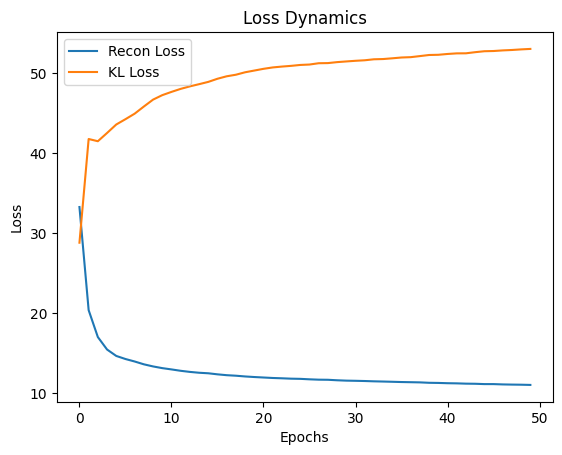

In [ ]:
plt.plot(vae.history.history['reconstruction_loss'], label='Recon Loss')
plt.plot(vae.history.history['kl_loss'], label='KL Loss')
plt.title('Loss Dynamics')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


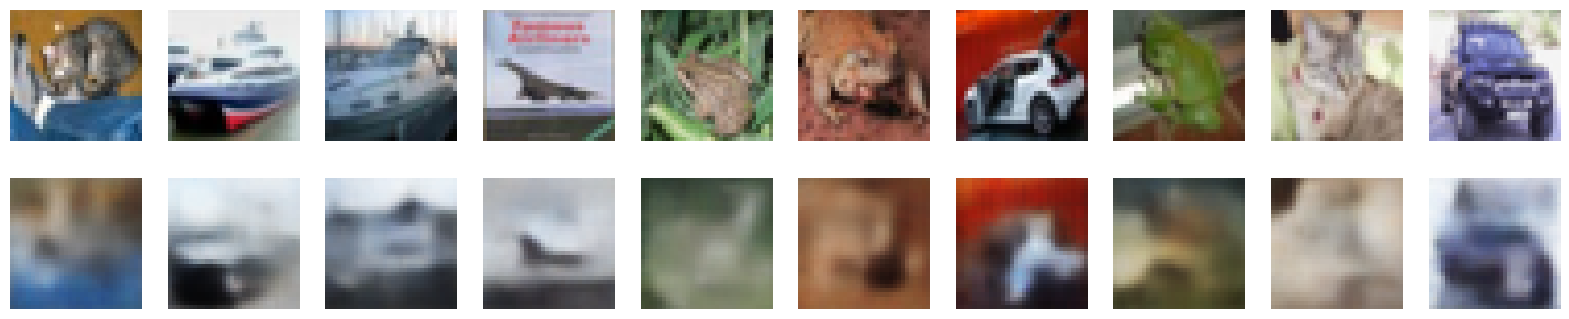

In [ ]:
test_reconstructions = vae.decoder.predict(encoder.predict(x_test[:10])[2], verbose=0)
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(2, 10, i + 1)
    plt.imshow(x_test[i])
    plt.axis("off")

    ax = plt.subplot(2, 10, i + 11)
    plt.imshow(test_reconstructions[i])
    plt.axis("off")
plt.show()

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


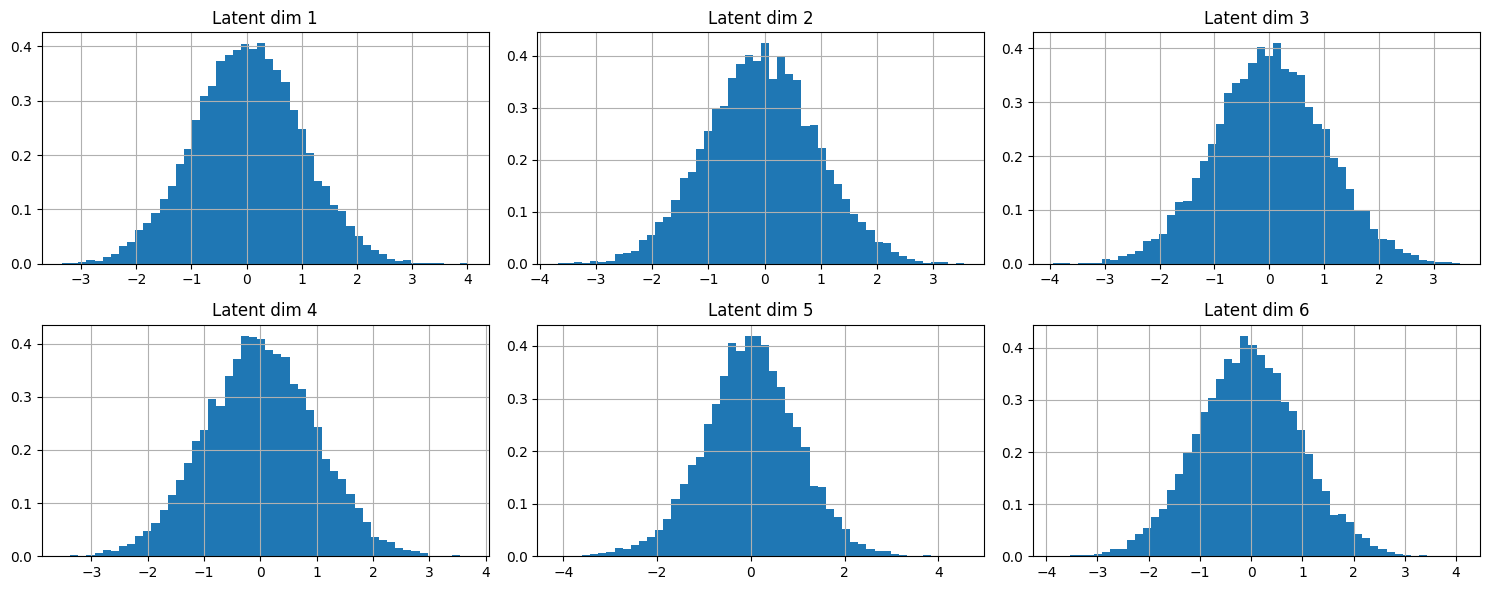

In [ ]:
_, _, latent_vectors = encoder.predict(x_test, batch_size=128, verbose=1)

# Визуализация распределения случайных 6 компонент латентного пространства (оно нормальное, а значит всё хорошо)
plt.figure(figsize=(15, 6))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.hist(latent_vectors[:, np.random.randint(0, latent_dim)], bins=50, density=True)
    plt.title(f"Latent dim {i+1}")
    plt.grid(True)
plt.tight_layout()
plt.show()

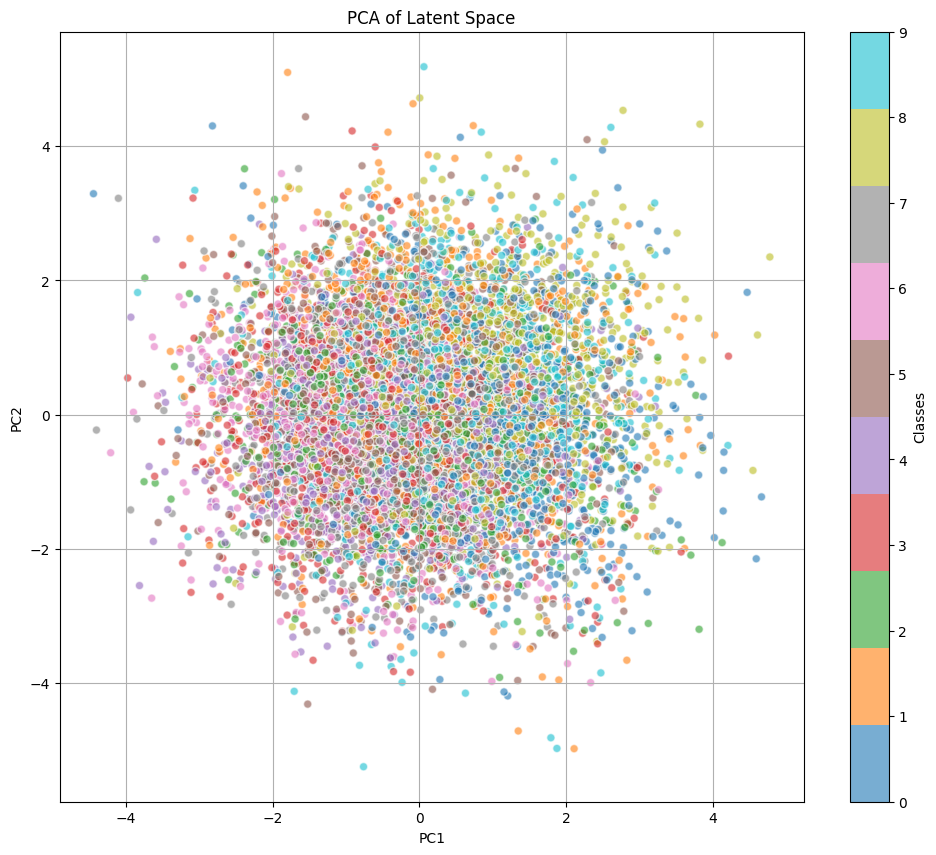

In [ ]:
from sklearn.decomposition import PCA

# Проекция на 2 главные компоненты
pca = PCA(n_components=2)
latent_2d = pca.fit_transform(latent_vectors)

# Визуализация
plt.figure(figsize=(12, 10))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=y_test.flatten(),
            cmap='tab10', alpha=0.6, edgecolors='w')
plt.colorbar(ticks=range(10), label='Classes')
plt.title("PCA of Latent Space")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

# Визуализация проекций картинок на две главные компоненты в латентном пространстве автоэнкодера показывает, что все изображения находятся в ограниченной области и распределны нормально

In [ ]:
class_means = []
for class_idx in range(10):
    class_images = x_train[y_train.flatten() == class_idx]
    _, _, latent_vectors = encoder.predict(class_images, verbose=0)
    class_means.append(np.mean(latent_vectors, axis=0))

In [ ]:
# Генерация всех векторов сразу
noise_scale = 0
generated_images = []
generated_labels = []

for class_idx in range(10):
    # Генерируем все векторы для класса одним вызовом
    mean_vector = class_means[class_idx]
    noise = np.random.normal(scale=noise_scale,
                            size=(5000, latent_dim))
    latent_vectors = mean_vector + noise

    # Декодируем батчами по 256
    class_images = []
    for batch in np.array_split(latent_vectors, 5000//256 + 1):
        images = decoder.predict(batch, verbose=0)
        class_images.append(images)

    generated_images.append(np.concatenate(class_images))
    generated_labels.extend([class_idx]*5000)

generated_images = np.concatenate(generated_images)
generated_labels = np.array(generated_labels)

In [ ]:
print(generated_images.shape)  # Должно быть (50000, 32, 32, 3)
print(generated_labels.shape)  # Должно быть (50000,)

(50000, 32, 32, 3)
(50000,)


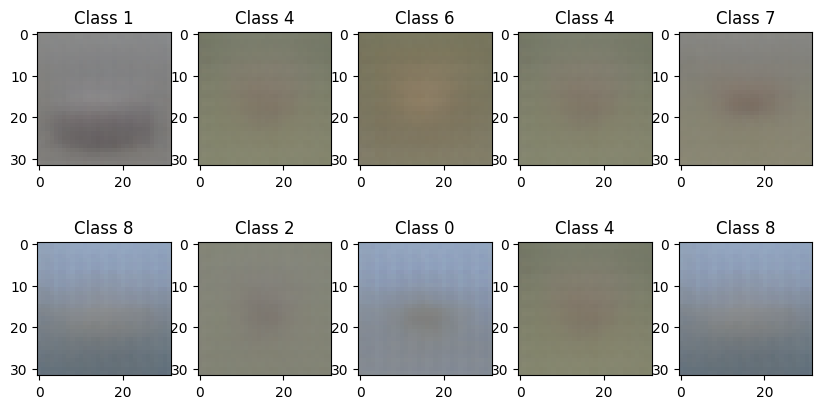

In [ ]:
import random

plt.figure(figsize=(10,5))
for i in range(10):
    plt.subplot(2,5,i+1)
    idx = random.randint(1, 50000)
    plt.imshow(generated_images[idx])
    plt.title(f"Class {generated_labels[idx]}")
plt.show()

In [ ]:
generated_labels_onehot = to_categorical(generated_labels, num_classes=10)
y_test_onehot = to_categorical(y_test, num_classes=10)

In [ ]:
model = keras.Sequential([
    layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', input_shape=(32, 32, 3), padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.Conv2D(filters=512, kernel_size=(3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.SpatialDropout2D(rate=0.2),
    layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Flatten(),
    layers.Dense(units=1024, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(units=10, activation='softmax')
])

#print(model.summary())

# Компиляция нейросети (выбор оптимизатора, функции ошибки и характеристики точности нейросети)
#my_optimizer = keras.optimizers.SGD(learning_rate = 0.01, nesterov = True)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Остановка обучения, если точность в выборке валидации долго не изменяется
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    mode='auto',
    patience=3,
    verbose=1
)

Epoch 1/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 59s 54ms/step - accuracy: 0.9451 - loss: 0.3578 - val_accuracy: 0.1648 - val_loss: 348.4426
Epoch 2/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 67s 45ms/step - accuracy: 0.9964 - loss: 0.0356 - val_accuracy: 0.1797 - val_loss: 91.4789
Epoch 3/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 40s 43ms/step - accuracy: 1.0000 - loss: 3.2530e-06 - val_accuracy: 0.1794 - val_loss: 92.4748
Epoch 4/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 0.9984 - loss: 0.0215 - val_accuracy: 0.1844 - val_loss: 285.7086
Epoch 5/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 36s 44ms/step - accuracy: 0.9993 - loss: 0.0082 - val_accuracy: 0.1595 - val_loss: 210.0018
Epoch 6/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 37s 44ms/step - accuracy: 0.9997 - loss: 0.0043 - val_accuracy: 0.1887 - val_loss: 164.2275
Epoch 7/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 1.0000 - loss: 6.8349e-07 - val_accuracy: 0.1884 - val_loss: 161.5406
Epoch 8/40
834/834 ━━━━━━━━━━━━━━━━━━━━ 36s 43ms/step - accuracy: 1.00

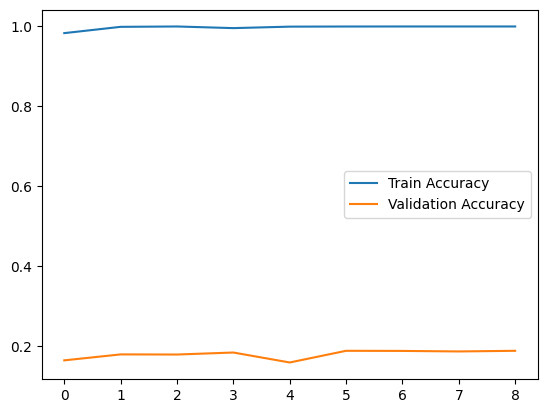

In [ ]:
history = model.fit(generated_images, generated_labels_onehot,
                    epochs=40,
                    batch_size=60,
                    validation_data=(x_test, y_test_onehot), callbacks=[early_stopping])

# Визуализация результатов
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()